In [12]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#normalization
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#splitting and feature selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

#model
from sklearn.neighbors import KNeighborsClassifier

#evaluation
from sklearn import metrics

In [65]:
def soilrm(df):
    df2 = df[df["Classification"] != "soil"]
    soil = df[df["Classification"] == "soil"]
    return df2, soil

In [68]:
#box location for Alex
data_dir = "/Users/alexlukasiewicz/Box Sync/Spring 2023/Sci Machine Learning/Bio Team SDS384/Datasets"

#data import
cog = pd.read_csv(data_dir + "/Levy_2017_datasets/cogs_pfams_tigrfam_ko/cog_ratios.csv")

pfam = pd.read_csv(data_dir + "/Levy_2017_datasets/cogs_pfams_tigrfam_ko/pfam_ratios.csv")

dbcan = pd.read_csv(data_dir + "/dbcan4_outputs/dbcan_result.3772genomes.matrix.divided_by_gene_counts.tsv", sep="\t")

In [69]:
#Scale datasets and generate presence/ absence pfam dataframe (0,1)
dbcan = dbcan.rename(columns = {"taxonID" : "2016_taxon_oid"})

#add hgt % to dbcan dataset
dbcan = pd.merge(dbcan, cog[['2016_taxon_oid', 'Horizontally_Transferred_%']], 
                             on='2016_taxon_oid', 
                             how='left')

In [70]:
#remove soil from all three datasets 

cog, soilcog = soilrm(cog)

pfam, soilfam = soilrm(pfam)

dbcan, soilcan = soilrm(dbcan)

In [14]:
dbcan.describe()

,2016_taxon_oid,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,...,PL4,PL40,PL41,PL42,PL5,PL6,PL7,PL8,PL9,Horizontally_Transferred_%
count,3.261000e+03,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,...,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000
mean,2.400029e+09,0.000239,0.000056,0.000039,0.000383,0.000106,0.000011,0.000191,0.000178,0.000003,...,0.000007,0.000004,0.000001,0.000010,0.000020,0.000016,0.000042,0.000017,0.000022,3.206884
std,5.488273e+08,0.000195,0.000148,0.000092,0.000339,0.000145,0.000064,0.000222,0.000276,0.000022,...,0.000041,0.000047,0.000016,0.000054,0.000062,0.000090,0.000157,0.000089,0.000076,9.376052
min,6.370000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.524023e+09,0.000126,0.000000,0.000000,0.000148,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
50%,2.565957e+09,0.000241,0.000000,0.000000,0.000312,0.000000,0.000000,0.000159,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000
75%,2.585428e+09,0.000323,0.000000,0.000000,0.000536,0.000238,0.000000,0.000276,0.000267,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.660000
max,2.645728e+09,0.001379,0.002212,0.000598,0.002302,0.001967,0.000737,0.000917,0.001654,0.000395,...,0.000590,0.001142,0.000325,0.001201,0.000670,0.001137,0.003640,0.001492,0.000678,97.940000


In [15]:
#x and y variables
variables = dbcan.columns[:4]
classif = dbcan['Classification']

scaler = StandardScaler()
dbcan_normalized = pd.DataFrame(scaler.fit_transform(dbcan.iloc[:,4:]), columns = dbcan.iloc[:,4:].columns)
dbcan_normalized.head()

,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,CBM12,...,PL4,PL40,PL41,PL42,PL5,PL6,PL7,PL8,PL9,Horizontally_Transferred_%
0,0.066808,-0.378513,-0.423784,-0.389091,1.002863,-0.170719,2.537982,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.331415
1,0.136692,-0.378513,2.474260,-0.348927,1.096538,-0.170719,1.528209,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.313281
2,0.121340,-0.378513,2.441586,-0.357750,1.075959,-0.170719,2.681372,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.331415
3,1.317699,-0.378513,-0.423784,-0.400855,0.975425,-0.170719,2.484157,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.218343
4,0.123815,-0.378513,2.446855,-0.356327,1.079278,-0.170719,2.687882,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.294080


In [16]:
#checking for balance of PA:NPA counts
len(dbcan[dbcan['Classification'] == "NPA"])

2117

The data appears to be roughly 65% NPA, and 35% PA. It may be a good idea to stratify the train_test split function here 

In [25]:
#split the dataset, but stratify by classification
X_train, X_test, y_train, y_test = train_test_split(dbcan_normalized,
                                                    classif, test_size=0.33,
                                                    random_state=42, 
                                                    stratify=classif)

In [26]:
#feature selection using training dataset
from sklearn.feature_selection import SelectKBest

#evaluating accuracy
from sklearn import metrics

# select features 
selector = SelectKBest(k=50)
X_train_selected = selector.fit_transform(X_train,y_train)

neighbors = range(1,11)
accuracy = []

for n in neighbors:
    #fit using KNeighbors
    KNC = KNeighborsClassifier(n_neighbors = n)
    KNC.fit(X_train_selected, y_train)

    # select the same features on the test set, predict, and get the test accuracy:
    X_test_selected = selector.transform(X_test)
    y_pred = KNC.predict(X_test_selected)
    
    #log accuracy
    accuracy.append(metrics.accuracy_score(y_test, y_pred))


/usr/local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 12  21  56  84 139 151 281 338] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/var/folders/yf/pl2fqbcj153fvwq1yflkkhcm0000gn/T/ipykernel_48995/3294862785.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(neighbors, accuracy, 'bo-', color='steelblue')


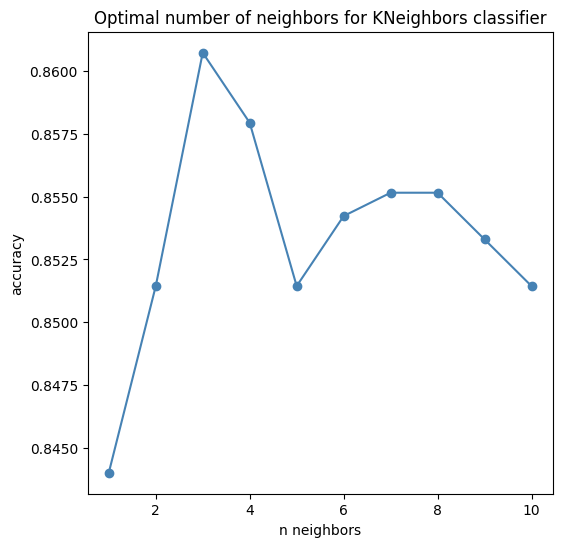

In [27]:
plt.figure(figsize=(6,6))
plt.plot(neighbors, accuracy, 'bo-', color='steelblue')
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.title('Optimal number of neighbors for KNeighbors classifier for dbcan dataset')
plt.show()


In [21]:
#fit using KNeighbors
KNC = KNeighborsClassifier(n_neighbors = 3)
KNC.fit(X_train_selected, y_train)

# select the same features on the test set, predict, and get the test accuracy:
X_test_selected = selector.transform(X_test)
y_pred = KNC.predict(X_test_selected)
    
#log accuracy
print("KNeighbors Accuracy Score for dbcan annotations is " + str(metrics.accuracy_score(y_test, y_pred)))

KNeighbors Accuracy Score for dbcan annotations is 0.8607242339832869


In [51]:
#feature selection using boruta scripts https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a#:~:text=During%20the%20fit%2C%20Boruta%20will,noise%2C%20and%20therefore%20worth%20keeping.

from sklearn.ensemble import RandomForestClassifier

# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
forest.fit(X_train, y_train)

from boruta import BorutaPy

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
feat_selector.fit(X_train, y_train)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train)

# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(data.feature_names, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))



InvalidIndexError: (slice(None, None, None), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
       312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
       325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337,
       338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348]))

What if we merge the COG percentages with the dbcan annotations?

In [33]:
columns = ['Classification', 'Horizontally_Transferred_%', "Gene_Count___*_assembled"]
merged = pd.merge(dbcan, cog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

merged.head()

,2016_taxon_oid,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#generate the variables and noramlize again
variables = merged.columns[:4]
classif = merged['Classification']

scaler = StandardScaler()
merged_norm = pd.DataFrame(scaler.fit_transform(merged.iloc[:,4:]), columns = merged.iloc[:,4:].columns)
merged_norm.head()

,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,CBM12,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,0.066808,-0.378513,-0.423784,-0.389091,1.002863,-0.170719,2.537982,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
1,0.136692,-0.378513,2.474260,-0.348927,1.096538,-0.170719,1.528209,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
2,0.121340,-0.378513,2.441586,-0.357750,1.075959,-0.170719,2.681372,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
3,1.317699,-0.378513,-0.423784,-0.400855,0.975425,-0.170719,2.484157,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
4,0.123815,-0.378513,2.446855,-0.356327,1.079278,-0.170719,2.687882,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738


/usr/local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  12   21   56   84  139  151  281  338 1228 1331 1454 1501 1633 1659
 1824 2068 2102 2974 4158 4430] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/var/folders/yf/pl2fqbcj153fvwq1yflkkhcm0000gn/T/ipykernel_48995/3977424692.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(neighbors, accuracy, 'bo-', color='steelblue')


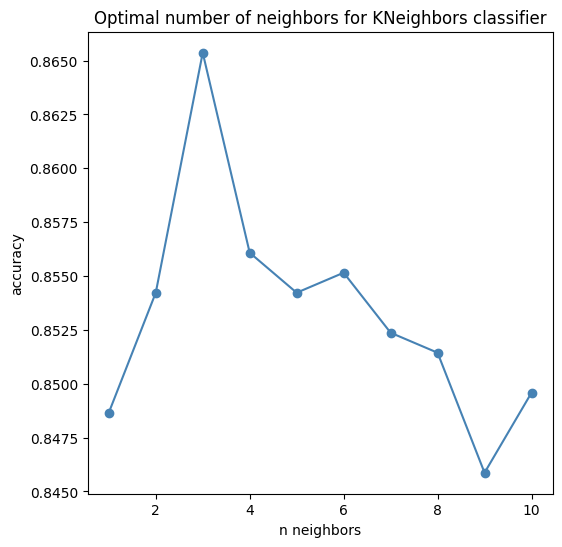

In [36]:
#split the dataset, but stratify by classification
X_train, X_test, y_train, y_test = train_test_split(merged_norm,
                                                    classif, test_size=0.33,
                                                    random_state=42, 
                                                    stratify=classif)


/usr/local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  12   21   56   84  139  151  281  338 1228 1331 1454 1501 1633 1659
 1824 2068 2102 2974 4158 4430] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/var/folders/yf/pl2fqbcj153fvwq1yflkkhcm0000gn/T/ipykernel_48995/1331045112.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(neighbors, accuracy, 'bo-', color='steelblue')


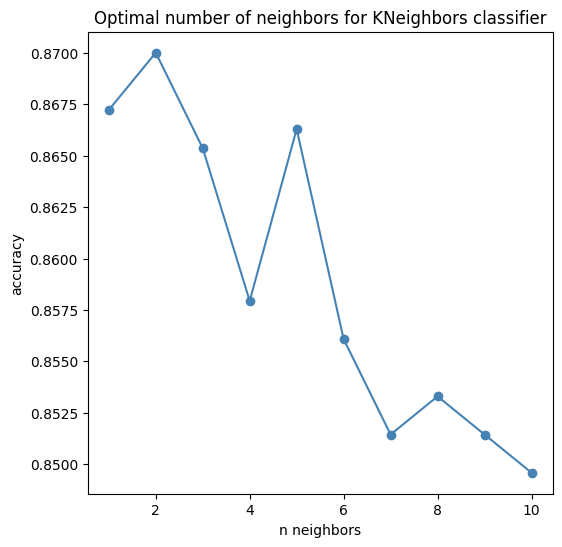

In [49]:
#feature selection using training dataset
from sklearn.feature_selection import SelectKBest

#evaluating accuracy
from sklearn import metrics

# select features 
selector = SelectKBest(k=500)
X_train_selected = selector.fit_transform(X_train,y_train)

#make dataframe with features for RFC
feature_names = X_train.columns[selector.get_support()].tolist()
X_train_labeled = pd.DataFrame(X_train_selected, columns=feature_names)


neighbors = range(1,11)
accuracy = []

for n in neighbors:
    #fit using KNeighbors
    KNC = KNeighborsClassifier(n_neighbors = n)
    KNC.fit(X_train_selected, y_train)

    # select the same features on the test set, predict, and get the test accuracy:
    X_test_selected = selector.transform(X_test)
    y_pred = KNC.predict(X_test_selected)
    
    #log accuracy
    accuracy.append(metrics.accuracy_score(y_test, y_pred))

plt.figure(figsize=(6,6))
plt.plot(neighbors, accuracy, 'bo-', color='steelblue')
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.title('Optimal number of neighbors for KNeighbors classifier on merged dbcan and cog %')
plt.show()


In [62]:
from sklearn.ensemble import RandomForestClassifier

#how does this compare to random forest? from Muyoung script
clf2 = RandomForestClassifier(max_depth=10, random_state=42)
clf2.fit(X_train_labeled, y_train)

# select the same features on the test set, predict, and get the test accuracy:
X_test_selected = selector.transform(X_test)
y_pred = clf2.predict(X_test_selected)

importances = clf2.feature_importances_
forest_importances = pd.Series(importances, index=clf2.feature_names_in_)
forest_importances.sort_values(ascending=False)[:40]

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


COG3386    0.026033
COG1129    0.022472
COG0837    0.017444
COG0798    0.016916
COG3569    0.014266
COG0667    0.013624
COG1529    0.012910
COG1609    0.012670
COG0467    0.012600
COG1349    0.012227
COG3734    0.011769
COG4214    0.011626
COG2217    0.010426
COG4191    0.010352
COG4567    0.010058
COG3146    0.008995
COG2085    0.008822
COG1177    0.008579
COG4213    0.008086
COG0297    0.007851
COG1868    0.007715
COG1319    0.007693
COG0569    0.007638
COG0624    0.007505
COG0524    0.007198
COG0607    0.006706
COG3845    0.006596
COG1273    0.006501
COG1523    0.006402
COG0601    0.006293
COG1766    0.006261
COG1801    0.006131
COG3847    0.005981
COG1172    0.005847
COG1874    0.005792
COG0765    0.005711
COG0474    0.005696
COG1987    0.005682
COG0673    0.005670
COG1082    0.005655
dtype: float64

Hooray! The top 3 COGs are all genes that encode for carbohydrate metabolising enzymes:

https://www.ncbi.nlm.nih.gov/research/cog/cog/COG3386/#

https://www.ncbi.nlm.nih.gov/Structure/cdd/COG1129

https://www.ncbi.nlm.nih.gov/research/cog/cog/COG0837/#

In [72]:
soil_dataset = pd.merge(soilcan, soilcog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

scaler = StandardScaler()
soil_norm = pd.DataFrame(scaler.fit_transform(soil_dataset.iloc[:,4:]), columns = soil_dataset.iloc[:,4:].columns)
soil_norm.head()

,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,CBM12,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,0.462913,-0.625204,-0.319784,-0.077318,0.686879,-0.189468,4.144194,-0.810045,-0.143771,-0.210686,...,-0.370132,-0.351246,-0.143073,-0.606353,-0.257713,-0.119156,-0.209364,-0.692661,-0.429728,-0.13197
1,0.410020,-0.625204,-0.319784,-0.103413,0.620996,-0.189468,2.386069,-0.810045,-0.143771,-0.210686,...,-0.370132,-0.351246,-0.143073,-0.606353,-0.257713,-0.119156,-0.209364,-0.692661,-0.429728,-0.13197
2,1.727213,-0.625204,3.009467,-0.127694,0.559694,-0.189468,2.276146,-0.810045,-0.143771,-0.210686,...,-0.370132,-0.351246,-0.143073,-0.606353,-0.257713,-0.119156,-0.209364,-0.692661,-0.429728,-0.13197
3,0.382872,-0.625204,-0.319784,0.568221,0.587180,-0.189468,3.876035,-0.810045,-0.143771,-0.210686,...,-0.370132,-0.351246,-0.143073,-0.606353,-0.257713,-0.119156,-0.209364,-0.692661,-0.429728,-0.13197
4,-0.300240,2.223318,-0.319784,-0.105831,-0.263711,2.117036,-0.775772,0.239899,-0.143771,-0.210686,...,-0.370132,-0.351246,-0.143073,-0.606353,-0.257713,-0.119156,-0.209364,-0.692661,-0.429728,-0.13197


In [77]:
X_soil = selector.transform(soil_norm)

RFpredict = clf2.predict(X_soil)
KNpredict = KNC.predict(X_soil)

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [78]:
soil_dataset['RFpred'] = RFpredict
soil_dataset['KNeighbors'] = KNpredict

In [81]:
len(soil_dataset)

511

In [85]:
#how often do they match?
num_matches = sum(soil_dataset['RFpred'] == soil_dataset['KNeighbors'])

print("random forest and KNeighbors have " +
      str(num_matches) + 
      " matching predictions and " +
      str(511 - num_matches) + " that do not match")

random forest and KNeighbors have 440 matching predictions and 71 that do not match
